In [1]:
import numpy as np
from math import acos, tan, radians, degrees, pi, sqrt, atan2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import matplotlib.colors as mcolors
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

# --- Physical and Conversion Constants ---
D_SS433_PC = 5500.0  # Distance to SS433 in parsecs
C_PC_PER_DAY = (299792.458 * 86400) / (3.08567758 * 10**13)
ARCSEC_PER_RADIAN = (180.0 / pi) * 3600.0

plt.rcParams['figure.dpi'] = 400

In [2]:
def load_ss433_params(source='russian'):
    """
    Loads SS433 ephemeris parameters.
    - 'russian' is a simple precession-only model.
    - 'full_russian' includes nutation and orbital effects.
    """
    if source.lower() == 'eikenberry':
        # Eikenberry et al. parameters
        return {
            'model_type': 'simple',
            'jd0_precession': 2443562.23, 'precession_period': 162.375,
            'beta': 0.2647, 'theta': radians(20.92),
            'inclination': radians(78.05), 'prec_pa': radians(10.0)
        }
    elif source.lower() == 'russian':
        # Simple Cherepaschuk et al. 2025 parameters (precession only)
        return {
            'model_type': 'simple',
            'jd0_precession': 2400000.5 + 59898.78, 'precession_period': 160.14,
            'beta': 0.2591, 'theta': radians(19.64),
            'inclination': radians(78.92), 'prec_pa': radians(10.0)
        }
    elif source.lower() == 'full_russian':
        print("Loaded 'full_russian' ephemeris (Cherepaschuk 2025).")
        # Full model including orbital and nutational effects
        # Orbital parameters are pre-calculated for a modern epoch (around 2024)
        return {
            'model_type': 'full',
            # Precession
            'jd0_precession': 2400000.5 + 59898.78, 'precession_period': 160.14,
            'beta': 0.2591, 'theta': radians(19.64),
            'inclination': radians(78.92), 'prec_pa': radians(10.0),
            'phi0': radians(-49.0), # Precession phase offset
            # Nutation
            'jd0_nut': 2400000.5 + 59797.68, 'nut_period': 6.28802,
            'nut_ampl': radians(0.0063 * (180/pi)), # nutation amplitude in cone angle
            # Orbit
            'jd0_orb': 2460503.14, 'orbital_period': 13.082989,
            'beta_orb_ampl': 0.004, 'beta_orb_phase0': pi # 0.5 * orbital period phase offset
        }
    else: # Default to Gies
        print("Loaded Gies et al. 2002 ephemeris parameters (default).")
        return {
            'model_type': 'simple',
            'jd0_precession': 2451458.12, 'precession_period': 162.15,
            'beta': 0.2602, 'theta': radians(19.85),
            'inclination': radians(78.83), 'prec_pa': radians(10.0)
        }

def get_precession_limits(params):
    """Calculates the min/max PA for each jet over a full precession cycle."""
    num_points = 720
    jd_cycle = params['jd0_precession'] + np.linspace(0, params['precession_period'], num_points)
    *_, pa_blue_cycle, pa_red_cycle = ss433_phases(jd_cycle, params)
    
    return {
        'blue_min': np.min(pa_blue_cycle), 'blue_max': np.max(pa_blue_cycle),
        'red_min': np.min(pa_red_cycle),   'red_max': np.max(pa_red_cycle)
    }

def ss433_phases(jd_obs, params, beta_blue=None, beta_red=None):
    """
    Computes SS433 observables for an array of Julian Dates.
    The fitted beta is now correctly treated as the base velocity before
    other orbital/nutational effects are added.
    """
    # --- Unpack static parameters ---
    inc, chi = params['inclination'], params['prec_pa']

    # --- Determine the BASE jet velocity for each jet ---
    # This is either the value from the fit (beta_blue/red) or the default.
    base_beta_b = beta_blue if beta_blue is not None else params['beta']
    base_beta_r = beta_red if beta_red is not None else params['beta']

    # --- Initialize effective parameters with their base values ---
    effective_theta = params['theta']
    effective_beta_b = base_beta_b
    effective_beta_r = base_beta_r

    # --- Calculate precession angle (phi) ---
    prec_phase = ((jd_obs - params['jd0_precession']) / params['precession_period']) % 1.0
    if params.get('model_type') == 'full':
        phi = params['phi0'] - 2 * np.pi * prec_phase
    else: # Simple model
        phi = -2 * np.pi * prec_phase

    # --- Add Full Model Physics if specified ---
    if params.get('model_type') == 'full':
        # Calculate phases for other motions
        orb_phase = ((jd_obs - params['jd0_orb']) / params['orbital_period']) % 1.0
        nut_phase = ((jd_obs - params['jd0_nut']) / params['nut_period']) % 1.0

        # Apply nutation to the cone angle
        effective_theta += params['nut_ampl'] * np.cos(2 * np.pi * nut_phase)

        # Apply orbital velocity modulation to the base jet speed
        orb_velocity_term = params['beta_orb_ampl'] * np.sin(2 * np.pi * orb_phase + params['beta_orb_phase0'])
        effective_beta_b += orb_velocity_term
        effective_beta_r += orb_velocity_term

    # --- Core Geometric Projection (uses final effective parameters) ---
    sin_theta, cos_theta = np.sin(effective_theta), np.cos(effective_theta)
    sin_inc, cos_inc = np.sin(inc), np.cos(inc)
    sin_phi, cos_phi = np.sin(phi), np.cos(phi)
    sin_chi, cos_chi = np.sin(chi), np.cos(chi)

    mu = (sin_theta * sin_inc * cos_phi + cos_theta * cos_inc)

    v_ra = (sin_chi * sin_theta * sin_phi + cos_chi * sin_inc * cos_theta -
            cos_chi * cos_inc * sin_theta * cos_phi)
    v_dec = (cos_chi * sin_theta * sin_phi - sin_chi * sin_inc * cos_theta +
             sin_chi * cos_inc * sin_theta * cos_phi)

    # Proper motions in units of c, using the final effective beta for each jet
    mu_red_ra = -effective_beta_r * v_ra / (1 + effective_beta_r * mu)
    mu_red_dec = -effective_beta_r * v_dec / (1 + effective_beta_r * mu)
    mu_blue_ra = effective_beta_b * v_ra / (1 - effective_beta_b * mu)
    mu_blue_dec = effective_beta_b * v_dec / (1 - effective_beta_b * mu)

    # Position Angle (degrees, E of N)
    pa_blue = np.degrees(np.arctan2(mu_blue_ra, mu_blue_dec))
    pa_red = np.degrees(np.arctan2(mu_red_ra, mu_red_dec))

    return mu_blue_ra, mu_blue_dec, mu_red_ra, mu_red_dec, pa_blue, pa_red

In [3]:
def calculate_outlier_travel_time(blob_data, jet_type, limits, params):
    """
    For an outlier jet, calculates the travel time assuming its velocity
    is entirely in the plane of the sky.
    """
    rad_obs = blob_data['rad_obs']
    
    # The apparent angular velocity in the plane of the sky is just beta.
    # v_ang is in units of c.
    v_ang_c = params['beta']
    
    # Convert angular speed to arcsec/day
    v_ang_arcsec_per_day = (v_ang_c * C_PC_PER_DAY / D_SS433_PC) * ARCSEC_PER_RADIAN

    if v_ang_arcsec_per_day < 1e-9: 
        return {'travel_time': np.inf}

    # Time = distance / speed
    travel_time = rad_obs / v_ang_arcsec_per_day
    
    # We don't need the limit_pa for the calculation anymore, but we return a placeholder
    return {'travel_time': travel_time, 'limit_pa': None}

def calculate_beta_error_bounds(blob_data, best_fit_beta, params, mjd_obs, beta_bounds_tuple):
    """
    Calculates error bounds for beta by finding the range of beta values
    where the model trajectory intersects the 1-sigma error ellipse of the data.
    
    Now uses the same bounds as the main fit.
    """
    # Helper function to check for intersection at a given beta
    def check_intersection(beta_test):
        age_curve = np.linspace(10, 400, 1000)
        jd_ej_curve = (mjd_obs + 2400000.5) - age_curve
        
        is_blue = blob_data['comp'] == 'g2'
        beta_b = beta_test if is_blue else params['beta']
        beta_r = beta_test if not is_blue else params['beta']
        
        mu_b_ra, mu_b_dec, mu_r_ra, mu_r_dec, _, _ = ss433_phases(
            jd_ej_curve, params, beta_blue=beta_b, beta_red=beta_r)
        
        pa_rad = np.deg2rad(blob_data['pa_obs'])
        sig_r = (blob_data['rad_err_U'] + abs(blob_data['rad_err_L'])) / 2.0
        sig_pa_rad = np.deg2rad((blob_data['pa_err_U'] + abs(blob_data['pa_err_L'])) / 2.0)
        sig_x_sq = max((np.sin(pa_rad) * sig_r)**2 + (blob_data['rad_obs'] * np.cos(pa_rad) * sig_pa_rad)**2, 1e-9)
        sig_y_sq = max((np.cos(pa_rad) * sig_r)**2 + (blob_data['rad_obs'] * -np.sin(pa_rad) * sig_pa_rad)**2, 1e-9)
        
        x_obs = blob_data['rad_obs'] * np.sin(pa_rad)
        y_obs = blob_data['rad_obs'] * np.cos(pa_rad)
        
        mu_ra = mu_b_ra if is_blue else mu_r_ra
        mu_dec = mu_b_dec if is_blue else mu_r_dec
        
        rad_curve = (np.sqrt(mu_ra**2 + mu_dec**2) * C_PC_PER_DAY * age_curve / D_SS433_PC) * ARCSEC_PER_RADIAN
        pa_rad_curve = np.arctan2(mu_ra, mu_dec)
        x_model, y_model = rad_curve * np.sin(pa_rad_curve), rad_curve * np.cos(pa_rad_curve)
        
        chi_sq_curve = ((x_model - x_obs)**2 / sig_x_sq) + ((y_model - y_obs)**2 / sig_y_sq)
        return np.min(chi_sq_curve) <= 1.0

    # UPDATED: Use the passed-in bounds for the scan range
    beta_min, beta_max = beta_bounds_tuple
    beta_scan_range = np.linspace(beta_min, beta_max, 241)
    
    intersecting_betas = [b for b in beta_scan_range if check_intersection(b)]

    if not intersecting_betas:
        print(f"--> WARNING: No model intersects the 1-sigma error ellipse for component {blob_data['comp']}. Cannot determine error bounds.")
        return np.nan, np.nan
        
    lower_bound = min(intersecting_betas)
    upper_bound = max(intersecting_betas)
    
    return lower_bound, upper_bound

def fit_and_calculate_jets(blob_data_list, params, regularization_strength=0):
    """
    Analyzes a jet pair by fitting each eligible jet independently.
    """
    try:
        blob_blue = next(b for b in blob_data_list if b['comp'] == 'g2')
        red_comp_name = sorted([b['comp'] for b in blob_data_list])[-1]
        blob_red = next(b for b in blob_data_list if b['comp'] == red_comp_name)
    except (StopIteration, IndexError):
        return {'success': False, 'message': "Could not identify jet pair."}

    mjd_obs = blob_data_list[0]['mjd_obs']
    limits = get_precession_limits(params)
    leeway = 10.0
    
    results = {'mjd_obs': mjd_obs, 'success': True, 'jets': {}}
    jets_to_fit = []

    # --- Stage 1: Initial Classification based on Position Angle ---
    # (This section is unchanged)
    pa_blue_obs = blob_blue['pa_obs']
    if limits['blue_min'] - leeway <= pa_blue_obs <= limits['blue_max'] + leeway:
        results['jets']['blue'] = {'method': 'fit'}
        jets_to_fit.append('blue')
    else:
        calc = calculate_outlier_travel_time(blob_blue, 'blue', limits, params)
        results['jets']['blue'] = {'method': 'calculate', **calc}

    pa_red_obs = blob_red['pa_obs']
    if limits['red_min'] - leeway <= pa_red_obs <= limits['red_max'] + leeway:
        results['jets']['red'] = {'method': 'fit'}
        jets_to_fit.append('red')
    else:
        calc = calculate_outlier_travel_time(blob_red, 'red', limits, params)
        results['jets']['red'] = {'method': 'calculate', **calc}

    # --- NEW LOGIC: Loop through and fit each jet INDEPENDENTLY ---
    if jets_to_fit:
        for jet_name in jets_to_fit:
            print(f"--- Attempting to fit {jet_name} jet...")
            
            # Define an objective function for only this single jet
            def get_single_jet_error(beta_to_fit):
                beta_val = beta_to_fit[0] # minimize sends a list
                
                # Setup parameters for the specific jet
                beta_b = beta_val if jet_name == 'blue' else params['beta']
                beta_r = beta_val if jet_name == 'red' else params['beta']
                blob_data = blob_blue if jet_name == 'blue' else blob_red

                # Calculate chi-squared for this jet
                age_curve = np.linspace(10, 400, 1000)
                jd_ej_curve = (mjd_obs + 2400000.5) - age_curve
                mu_b_ra,mu_b_dec,mu_r_ra,mu_r_dec,_,_ = ss433_phases(jd_ej_curve,params,beta_b,beta_r)
                
                pa_rad = np.deg2rad(blob_data['pa_obs'])
                x_obs, y_obs = blob_data['rad_obs'] * np.sin(pa_rad), blob_data['rad_obs'] * np.cos(pa_rad)
                sig_r = (blob_data['rad_err_U'] + abs(blob_data['rad_err_L'])) / 2.0
                sig_pa_rad = np.deg2rad((blob_data['pa_err_U'] + abs(blob_data['pa_err_L'])) / 2.0)
                sig_x_sq = max((np.sin(pa_rad) * sig_r)**2 + (blob_data['rad_obs'] * np.cos(pa_rad) * sig_pa_rad)**2, 1e-9)
                sig_y_sq = max((np.cos(pa_rad) * sig_r)**2 + (blob_data['rad_obs'] * -np.sin(pa_rad) * sig_pa_rad)**2, 1e-9)

                mu_ra = mu_b_ra if jet_name == 'blue' else mu_r_ra
                mu_dec = mu_b_dec if jet_name == 'blue' else mu_r_dec
                
                rad_curve = (np.sqrt(mu_ra**2 + mu_dec**2)*C_PC_PER_DAY*age_curve/D_SS433_PC)*ARCSEC_PER_RADIAN
                pa_curve = np.arctan2(mu_ra, mu_dec)
                x_model, y_model = rad_curve * np.sin(pa_curve), rad_curve * np.cos(pa_curve)
                
                chi_sq = np.min(((x_model-x_obs)**2/sig_x_sq) + ((y_model-y_obs)**2/sig_y_sq))
                penalty = (beta_val - params['beta'])**2
                
                return chi_sq + regularization_strength * penalty

            # Perform the 1D fit for this jet
            initial_guess = [params['beta']]
            bounds = [(0.2, 0.32)]
            res = minimize(get_single_jet_error, initial_guess, bounds=bounds, method='L-BFGS-B')

            if res.success:
                best_beta = res.x[0]
                blob_to_test = blob_blue if jet_name == 'blue' else blob_red
                lower, upper = calculate_beta_error_bounds(blob_to_test, best_beta, params, mjd_obs, bounds[0])
                
                results['jets'][jet_name]['fitted_beta'] = best_beta
                results['jets'][jet_name]['beta_lower_bound'] = lower
                results['jets'][jet_name]['beta_upper_bound'] = upper
            else:
                print(f"--> WARNING: Minimization failed for {jet_name} jet.")
                results['jets'][jet_name]['fitted_beta'] = np.nan
                results['jets'][jet_name]['beta_lower_bound'] = np.nan
                results['jets'][jet_name]['beta_upper_bound'] = np.nan

    # --- Stage 2: Re-classify fits that failed or resulted in NaN errors ---
    # (This section is unchanged)
    for jet_name in ['blue', 'red']:
        if results['jets'][jet_name]['method'] == 'fit':
            if pd.isna(results['jets'][jet_name].get('beta_lower_bound')):
                print(f"--> INFO: Fit for {jet_name} jet was poor (NaN errors). Reverting to 'calculate' method.")
                blob_data = blob_blue if jet_name == 'blue' else blob_red
                calc_results = calculate_outlier_travel_time(blob_data, jet_name, limits, params)
                results['jets'][jet_name] = {'method': 'calculate', **calc_results}

    # --- Finalize the 'fitted_betas' dictionary used for plotting ---
    # (This section is unchanged)
    final_fitted_betas = {}
    for jet_name in ['blue', 'red']:
        if results['jets'][jet_name]['method'] == 'fit':
            final_fitted_betas[jet_name] = results['jets'][jet_name]['fitted_beta']
        else:
            final_fitted_betas[jet_name] = params['beta']
    results['fitted_betas'] = final_fitted_betas

    print("--- Analysis complete. ---")
    return results

In [4]:
def _get_closest_geometric_point(blob_data, jet_type, fit_results, params):
    """
    Helper to find the closest point on a model curve and its age.
    UPDATED to use chi-squared distance to be consistent with the fitter.
    """
    # --- Calculate observed position and errors in Cartesian coordinates ---
    pa_obs_rad = np.deg2rad(blob_data['pa_obs'])
    x_obs = blob_data['rad_obs'] * np.sin(pa_obs_rad)
    y_obs = blob_data['rad_obs'] * np.cos(pa_obs_rad)
    
    sig_r = (blob_data['rad_err_U'] + abs(blob_data['rad_err_L'])) / 2.0
    sig_pa_rad = np.deg2rad((blob_data['pa_err_U'] + abs(blob_data['pa_err_L'])) / 2.0)
    sig_x_sq = max((np.sin(pa_obs_rad) * sig_r)**2 + (blob_data['rad_obs'] * np.cos(pa_obs_rad) * sig_pa_rad)**2, 1e-9)
    sig_y_sq = max((np.cos(pa_obs_rad) * sig_r)**2 + (blob_data['rad_obs'] * -np.sin(pa_obs_rad) * sig_pa_rad)**2, 1e-9)

    # --- Generate the model trajectory for the best-fit beta ---
    age_curve = np.linspace(10, 400, 1000)
    jd_ej_curve = (fit_results['mjd_obs'] + 2400000.5) - age_curve
    
    beta_b = fit_results['fitted_betas']['blue']
    beta_r = fit_results['fitted_betas']['red']
    
    mu_b_ra, mu_b_dec, mu_r_ra, mu_r_dec, pa_b, pa_r = ss433_phases(
        jd_ej_curve, params, beta_blue=beta_b, beta_red=beta_r
    )
    
    if jet_type == 'blue':
        rad_curve = (np.sqrt(mu_b_ra**2 + mu_b_dec**2) * C_PC_PER_DAY * age_curve / D_SS433_PC) * ARCSEC_PER_RADIAN
        pa_curve = pa_b
    else: # 'red'
        rad_curve = (np.sqrt(mu_r_ra**2 + mu_r_dec**2) * C_PC_PER_DAY * age_curve / D_SS433_PC) * ARCSEC_PER_RADIAN
        pa_curve = pa_r

    x_model = rad_curve * np.sin(np.deg2rad(pa_curve))
    y_model = rad_curve * np.cos(np.deg2rad(pa_curve))

    # --- UPDATED: Find the index that minimizes CHI-SQUARED distance ---
    chi_sq_dist_curve = ((x_model - x_obs)**2 / sig_x_sq) + ((y_model - y_obs)**2 / sig_y_sq)
    idx = np.argmin(chi_sq_dist_curve)
    
    return {
        'model_pa': pa_curve[idx], 
        'model_rad': rad_curve[idx],
        'model_age': age_curve[idx]
    }

def _plot_jet_trajectories_on_ax(ax, mjd_obs, params, mappable, r_max, betas=None):
    jd_obs = mjd_obs + 2400000.5
    beta_b = betas['blue'] if betas else params['beta']
    beta_r = betas['red'] if betas else params['beta']
    
    t_travel = np.linspace(1.0, 325, 1000)
    jd_ej = jd_obs - t_travel
    
    mu_b_ra, mu_b_dec, mu_r_ra, mu_r_dec, pa_b, pa_r = ss433_phases(jd_ej, params, beta_blue=beta_b, beta_red=beta_r)
    
    rad_b = (np.sqrt(mu_b_ra**2 + mu_b_dec**2) * C_PC_PER_DAY * t_travel / D_SS433_PC) * ARCSEC_PER_RADIAN
    rad_r = (np.sqrt(mu_r_ra**2 + mu_r_dec**2) * C_PC_PER_DAY * t_travel / D_SS433_PC) * ARCSEC_PER_RADIAN
    
    cmap, norm = mappable.get_cmap(), mappable.norm
    ax.scatter(np.deg2rad(pa_b), rad_b, c=t_travel, cmap=cmap, norm=norm, s=15, zorder=1)
    ax.scatter(np.deg2rad(pa_r), rad_r, c=t_travel, cmap=cmap, norm=norm, s=15, zorder=1)
    
    limits = get_precession_limits(params)
    ax.plot([0, np.deg2rad(limits['blue_min'])], [0, r_max+1], color='deepskyblue', ls='--', lw=1, zorder=0.1)
    ax.plot([0, np.deg2rad(limits['blue_max'])], [0, r_max+1], color='deepskyblue', ls='--', lw=1, zorder=0.1)
    ax.plot([0, np.deg2rad(limits['red_min'])], [0, r_max+1], color='lightcoral', ls='--', lw=1, zorder=0.1)
    ax.plot([0, np.deg2rad(limits['red_max'])], [0, r_max+1], color='lightcoral', ls='--', lw=1, zorder=0.1)
    
    ax.plot(0, 0, '*', color='gold', markersize=15, zorder=10)
    ax.set_theta_zero_location("N"); ax.set_theta_direction(1); ax.grid(True, linestyle=':', alpha=0.7)

def _plot_jet_error_region_on_ax(ax, jet_type, fit_results, params, mappable):
    """
    Draws a shaded, color-graded error region for a jet based on its
    beta error bounds.
    """
    # Extract the beta bounds for the specified jet
    try:
        if jet_type == 'blue':
            lower_beta = fit_results['jets']['blue']['beta_lower_bound']
            upper_beta = fit_results['jets']['blue']['beta_upper_bound']
        else: # 'red'
            lower_beta = fit_results['jets']['red']['beta_lower_bound']
            upper_beta = fit_results['jets']['red']['beta_upper_bound']
    except KeyError:
        return # No fit data available

    # If bounds could not be determined, do nothing
    if pd.isna(lower_beta) or pd.isna(upper_beta):
        return

    mjd_obs = fit_results['mjd_obs']
    jd_obs = mjd_obs + 2400000.5
    
    # Generate the time and model arrays
    t_travel = np.linspace(0.0, 325, 1000)
    jd_ej = jd_obs - t_travel

    # --- Calculate the two bounding trajectories ---
    # Lower bound trajectory
    beta_b_low = lower_beta if jet_type == 'blue' else params['beta']
    beta_r_low = lower_beta if jet_type == 'red' else params['beta']
    mu_b_ra_l, mu_b_dec_l, mu_r_ra_l, mu_r_dec_l, pa_b_l, pa_r_l = ss433_phases(
        jd_ej, params, beta_blue=beta_b_low, beta_red=beta_r_low)

    # Upper bound trajectory
    beta_b_upp = upper_beta if jet_type == 'blue' else params['beta']
    beta_r_upp = upper_beta if jet_type == 'red' else params['beta']
    mu_b_ra_u, mu_b_dec_u, mu_r_ra_u, mu_r_dec_u, pa_b_u, pa_r_u = ss433_phases(
        jd_ej, params, beta_blue=beta_b_upp, beta_red=beta_r_upp)

    # Select the correct jet data based on type
    if jet_type == 'blue':
        rad_low = (np.sqrt(mu_b_ra_l**2 + mu_b_dec_l**2) * C_PC_PER_DAY * t_travel / D_SS433_PC) * ARCSEC_PER_RADIAN
        pa_low_rad = np.deg2rad(pa_b_l)
        rad_upp = (np.sqrt(mu_b_ra_u**2 + mu_b_dec_u**2) * C_PC_PER_DAY * t_travel / D_SS433_PC) * ARCSEC_PER_RADIAN
        pa_upp_rad = np.deg2rad(pa_b_u)
    else: # 'red'
        rad_low = (np.sqrt(mu_r_ra_l**2 + mu_r_dec_l**2) * C_PC_PER_DAY * t_travel / D_SS433_PC) * ARCSEC_PER_RADIAN
        pa_low_rad = np.deg2rad(pa_r_l)
        rad_upp = (np.sqrt(mu_r_ra_u**2 + mu_r_dec_u**2) * C_PC_PER_DAY * t_travel / D_SS433_PC) * ARCSEC_PER_RADIAN
        pa_upp_rad = np.deg2rad(pa_r_u)

    # --- Draw many small, colored polygons to create a gradient fill ---
    for i in range(len(t_travel) - 1):
        # Define the 4 vertices of the small polygon segment
        thetas = [pa_low_rad[i], pa_upp_rad[i], pa_upp_rad[i+1], pa_low_rad[i+1]]
        rads = [rad_low[i], rad_upp[i], rad_upp[i+1], rad_low[i+1]]
        
        # Get the color for this segment from the travel time
        avg_time = (t_travel[i] + t_travel[i+1]) / 2.0
        color = mappable.to_rgba(avg_time)
        
        # Draw the filled polygon segment
        ax.fill(thetas, rads, color=color,edgecolor='none', alpha=0.5, zorder=0.5)

def plot_fit_and_calc_results(blob_data_list, fit_results, params, pdf_object=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9), subplot_kw={'projection': 'polar'})

    fig.suptitle(f"Observation ID: {obs_id}", fontsize=20, y=0.97)
    
    mjd_obs = fit_results['mjd_obs']
    blob_blue = next(b for b in blob_data_list if b['comp'] == 'g2')
    blob_red = next(b for b in blob_data_list if b['comp'] != 'g2')
    
    max_rad = max(b['rad_obs'] + b['rad_err_U'] for b in blob_data_list)
    common_rmax = max(1.3, max_rad * 1.2)
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=mcolors.Normalize(vmin=1.0, vmax=225))
    
    # Left Plot: Model with default beta
    _plot_jet_trajectories_on_ax(ax1, mjd_obs, params, mappable, common_rmax)
    ax1.set_title(f"Model at MJD {mjd_obs:.1f}\n(Default Beta = {params['beta']:.4f})", pad=20, fontsize=14)

    # Right Plot: Model with fitted/calculated results
    _plot_jet_trajectories_on_ax(ax2, mjd_obs, params, mappable, common_rmax, betas=fit_results['fitted_betas'])
    
    # --- NEW: Add the shaded error regions to the right plot ---
    _plot_jet_error_region_on_ax(ax2, 'blue', fit_results, params, mappable)
    _plot_jet_error_region_on_ax(ax2, 'red', fit_results, params, mappable)
    
    ax2.set_title(f"Fit/Calculation Results at MJD {mjd_obs:.1f}", pad=20, fontsize=14)

    # Plot observed blobs on both axes
    for ax in [ax1, ax2]:
        ax.errorbar(np.deg2rad(blob_blue['pa_obs']), blob_blue['rad_obs'], yerr=[[abs(blob_blue['rad_err_L'])], [abs(blob_blue['rad_err_U'])]], xerr=[[np.deg2rad(abs(blob_blue['pa_err_L']))], [np.deg2rad(abs(blob_blue['pa_err_U']))]], fmt='o', color='blue', ecolor='gray', capsize=3, zorder=3, label="Observed Blue Jet")
        ax.errorbar(np.deg2rad(blob_red['pa_obs']), blob_red['rad_obs'], yerr=[[abs(blob_red['rad_err_L'])], [abs(blob_red['rad_err_U'])]], xerr=[[np.deg2rad(abs(blob_red['pa_err_L']))], [np.deg2rad(abs(blob_red['pa_err_U']))]], fmt='o', color='red', ecolor='gray', capsize=3, zorder=3, label="Observed Red Jet")

    # --- Plot fit/calculation results on right axis ---
    if fit_results['jets']['blue']['method'] == 'fit':
        point = _get_closest_geometric_point(blob_blue, 'blue', fit_results, params)
        ax2.plot([np.deg2rad(blob_blue['pa_obs']), np.deg2rad(point['model_pa'])], [blob_blue['rad_obs'], point['model_rad']], ls='--', c='blue')
        beta_val, lower, upper = fit_results['jets']['blue']['fitted_beta'], fit_results['jets']['blue']['beta_lower_bound'], fit_results['jets']['blue']['beta_upper_bound']
        err_pos, err_neg = upper - beta_val, beta_val - lower
        label = f"Fitted Blue Jet (β={beta_val:.4f} +{err_pos:.4f} / -{err_neg:.4f}c)"
        ax2.plot(np.deg2rad(point['model_pa']), point['model_rad'], 'X', c='w', ms=5, mec='b',zorder=4, label=label)
    else:
        ax2.plot([0, np.deg2rad(blob_blue['pa_obs'])], [0, blob_blue['rad_obs']], ls=':', c='blue')
        time = fit_results['jets']['blue']['travel_time']
        ax2.text(0.95*np.deg2rad(blob_blue['pa_obs']), 0.95*blob_blue['rad_obs'], f" t≈{time:.0f}d", color='blue', ha='left', va='bottom', fontsize=9, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'))

    if fit_results['jets']['red']['method'] == 'fit':
        point = _get_closest_geometric_point(blob_red, 'red', fit_results, params)
        ax2.plot([np.deg2rad(blob_red['pa_obs']), np.deg2rad(point['model_pa'])], [blob_red['rad_obs'], point['model_rad']], ls='--', c='red')
        beta_val, lower, upper = fit_results['jets']['red']['fitted_beta'], fit_results['jets']['red']['beta_lower_bound'], fit_results['jets']['red']['beta_upper_bound']
        err_pos, err_neg = upper - beta_val, beta_val - lower
        label = f"Fitted Red Jet (β={beta_val:.4f} +{err_pos:.4f} / -{err_neg:.4f}c)"
        ax2.plot(np.deg2rad(point['model_pa']), point['model_rad'], 'X', c='w', ms=5, mec='r', zorder=4, label=label)
    else:
        ax2.plot([0, np.deg2rad(blob_red['pa_obs'])], [0, blob_red['rad_obs']], ls=':', c='red')
        time = fit_results['jets']['red']['travel_time']
        ax2.text(1.05*np.deg2rad(blob_red['pa_obs']), 1.05*blob_red['rad_obs'], f" t≈{time:.0f}d", color='red', ha='left', va='top', fontsize=9, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'))
    
    ax1.set_rmax(common_rmax)
    ax1.set_rmin(0)
    ax2.set_rmax(common_rmax)
    ax2.set_rmin(0)
    handles, labels = ax2.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax2.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(-0.265, 1.05), frameon=False, fontsize=11)
    
    fig.subplots_adjust(left=0.05, right=0.88, top=0.85, bottom=0.1, wspace=0)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(mappable, cax=cbar_ax)
    cbar.set_label('Travel Time / Age (Days)', fontsize=12)
    
    if pdf_object:
        pdf_object.savefig(fig)
        plt.close(fig)
    else:
        plt.show()

In [5]:
# --- 1. Setup Automation ---
ephem = 'russian'
ss433_params = load_ss433_params(source=ephem)

# Use your local file paths here
CSV_INPUT_PATH = '/Users/leodrake/Documents/MIT/ss433/HRC_2024/2Dfits/gaussian-component-data-4-comps-1sigma-jittercorr-0000-4040.csv'
PDF_OUTPUT_PATH = '/Users/leodrake/Documents/MIT/ss433/HRC_2024/2Dfits/ss433-jet-fit-results-4comp-1sigma-jittercorr-empPSF-0000-4040.pdf'
CSV_OUTPUT_PATH = '/Users/leodrake/Documents/MIT/ss433/HRC_2024/2Dfits/ss433-jet-fit-analysis-results-4comp-1sigma-jittercorr-empPSF-0000-4040.csv'

pdf_pages = PdfPages(PDF_OUTPUT_PATH)
all_results_data = []

# --- 2. Load Data ---
try:
    df = pd.read_csv(CSV_INPUT_PATH)
    print(f"Successfully loaded data from {CSV_INPUT_PATH}")
except FileNotFoundError:
    print(f"FATAL ERROR: CSV file not found at '{CSV_INPUT_PATH}'")
    df = pd.DataFrame()

# --- 3. Loop, Analyze, Plot, and Collect Results ---
if not df.empty:
    is_first_iteration = True
    
    for obs_id, group in df.groupby('obs_id'):
        print(f"\n--- Processing Observation ID: {obs_id} ---")
        
        blue_data = group[group['component'] == 'g2']
        if group.empty or blue_data.empty: continue
        
        red_comp_name = sorted(group['component'].unique())[-1]
        red_data = group[group['component'] == red_comp_name]

        if len(blue_data) == 1 and len(red_data) == 1 and 'g2' != red_comp_name:
            blue_row = blue_data.iloc[0]
            red_row = red_data.iloc[0]
            
            blob_pair_data = [
                {'mjd_obs': blue_row['mjd'], 'comp': 'g2', 'pa_obs': blue_row['PA'], 'rad_obs': blue_row['radius'], 'rad_err_U': blue_row['radius_plus_err'], 'rad_err_L': blue_row['radius_minus_err'], 'pa_err_U': blue_row['PA_err_plus'], 'pa_err_L': blue_row['PA_err_minus']},
                {'mjd_obs': red_row['mjd'], 'comp': red_comp_name, 'pa_obs': red_row['PA'], 'rad_obs': red_row['radius'], 'rad_err_U': red_row['radius_plus_err'], 'rad_err_L': red_row['radius_minus_err'], 'pa_err_U': red_row['PA_err_plus'], 'pa_err_L': red_row['PA_err_minus']}
            ]
            
            if is_first_iteration:
                reg_strength = 0#1237
                print(f"--> NOTE: Applying stronger regularization ({reg_strength}) for the first observation.")
                is_first_iteration = False
            else:
                reg_strength = 0

            analysis_results = fit_and_calculate_jets(blob_pair_data, ss433_params, regularization_strength=reg_strength)

            if analysis_results['success']:
                plot_fit_and_calc_results(blob_pair_data, analysis_results, ss433_params, pdf_object=pdf_pages)
                print(f"--> Successfully processed and saved plot for {obs_id}.")
                
                for jet_color in ['blue', 'red']:
                    jet_info = analysis_results['jets'][jet_color]
                    blob_data = blob_pair_data[0] if jet_color == 'blue' else blob_pair_data[1]
                    
                    row = {
                        'obs_id': obs_id,
                        'mjd': analysis_results['mjd_obs'],
                        'jet_color': jet_color,
                        'component_name': blob_data['comp'],
                        'method': jet_info['method'],
                        'beta': np.nan,
                        'beta_err_pos': np.nan,
                        'beta_err_neg': np.nan,
                        'travel_time_days': np.nan
                    }

                    if jet_info['method'] == 'fit':
                        beta_val = jet_info.get('fitted_beta')
                        lower = jet_info.get('beta_lower_bound')
                        upper = jet_info.get('beta_upper_bound')
                        row['beta'] = beta_val
                        if pd.notna(lower) and pd.notna(upper):
                            row['beta_err_pos'] = upper - beta_val
                            row['beta_err_neg'] = beta_val - lower
                        fitted_point = _get_closest_geometric_point(blob_data, jet_color, analysis_results, ss433_params)
                        row['travel_time_days'] = fitted_point.get('model_age')
                    else:
                        row['beta'] = ss433_params['beta']
                        row['travel_time_days'] = jet_info.get('travel_time')
                    
                    all_results_data.append(row)
            else:
                print(f"--> Processing failed for {obs_id}: {analysis_results.get('message', 'N/A')}")
        else:
            print(f"--> Skipping {obs_id}: did not find a valid blue/red jet pair.")

# --- 4. Finalize PDF and Save Tidy CSV Data ---
pdf_pages.close()
print(f"\nAll plots saved to '{PDF_OUTPUT_PATH}'")

if all_results_data:
    results_df = pd.DataFrame(all_results_data)
    column_order = ['obs_id', 'mjd', 'jet_color', 'component_name', 'method', 'beta', 'beta_err_pos', 'beta_err_neg', 'travel_time_days']
    results_df = results_df[column_order]
    
    results_df.to_csv(CSV_OUTPUT_PATH, index=False, float_format='%.5f')
    print(f"Analysis results saved to '{CSV_OUTPUT_PATH}'")
else:
    print("No data was processed, so no results CSV was created.")

Successfully loaded data from /Users/leodrake/Documents/MIT/ss433/HRC_2024/2Dfits/gaussian-component-data-4-comps-1sigma-jittercorr-0000-4040.csv

--- Processing Observation ID: 26568 ---
--> NOTE: Applying stronger regularization (0) for the first observation.
--- Attempting to fit blue jet...
--- Attempting to fit red jet...
--- Analysis complete. ---
--> Successfully processed and saved plot for 26568.

--- Processing Observation ID: 26569 ---
--- Attempting to fit blue jet...
--- Attempting to fit red jet...
--- Analysis complete. ---
--> Successfully processed and saved plot for 26569.

--- Processing Observation ID: 26570 ---
--- Attempting to fit blue jet...
--- Analysis complete. ---
--> Successfully processed and saved plot for 26570.

--- Processing Observation ID: 26571 ---
--- Attempting to fit blue jet...
--- Attempting to fit red jet...
--- Analysis complete. ---
--> Successfully processed and saved plot for 26571.

--- Processing Observation ID: 26572 ---
--- Attempting 

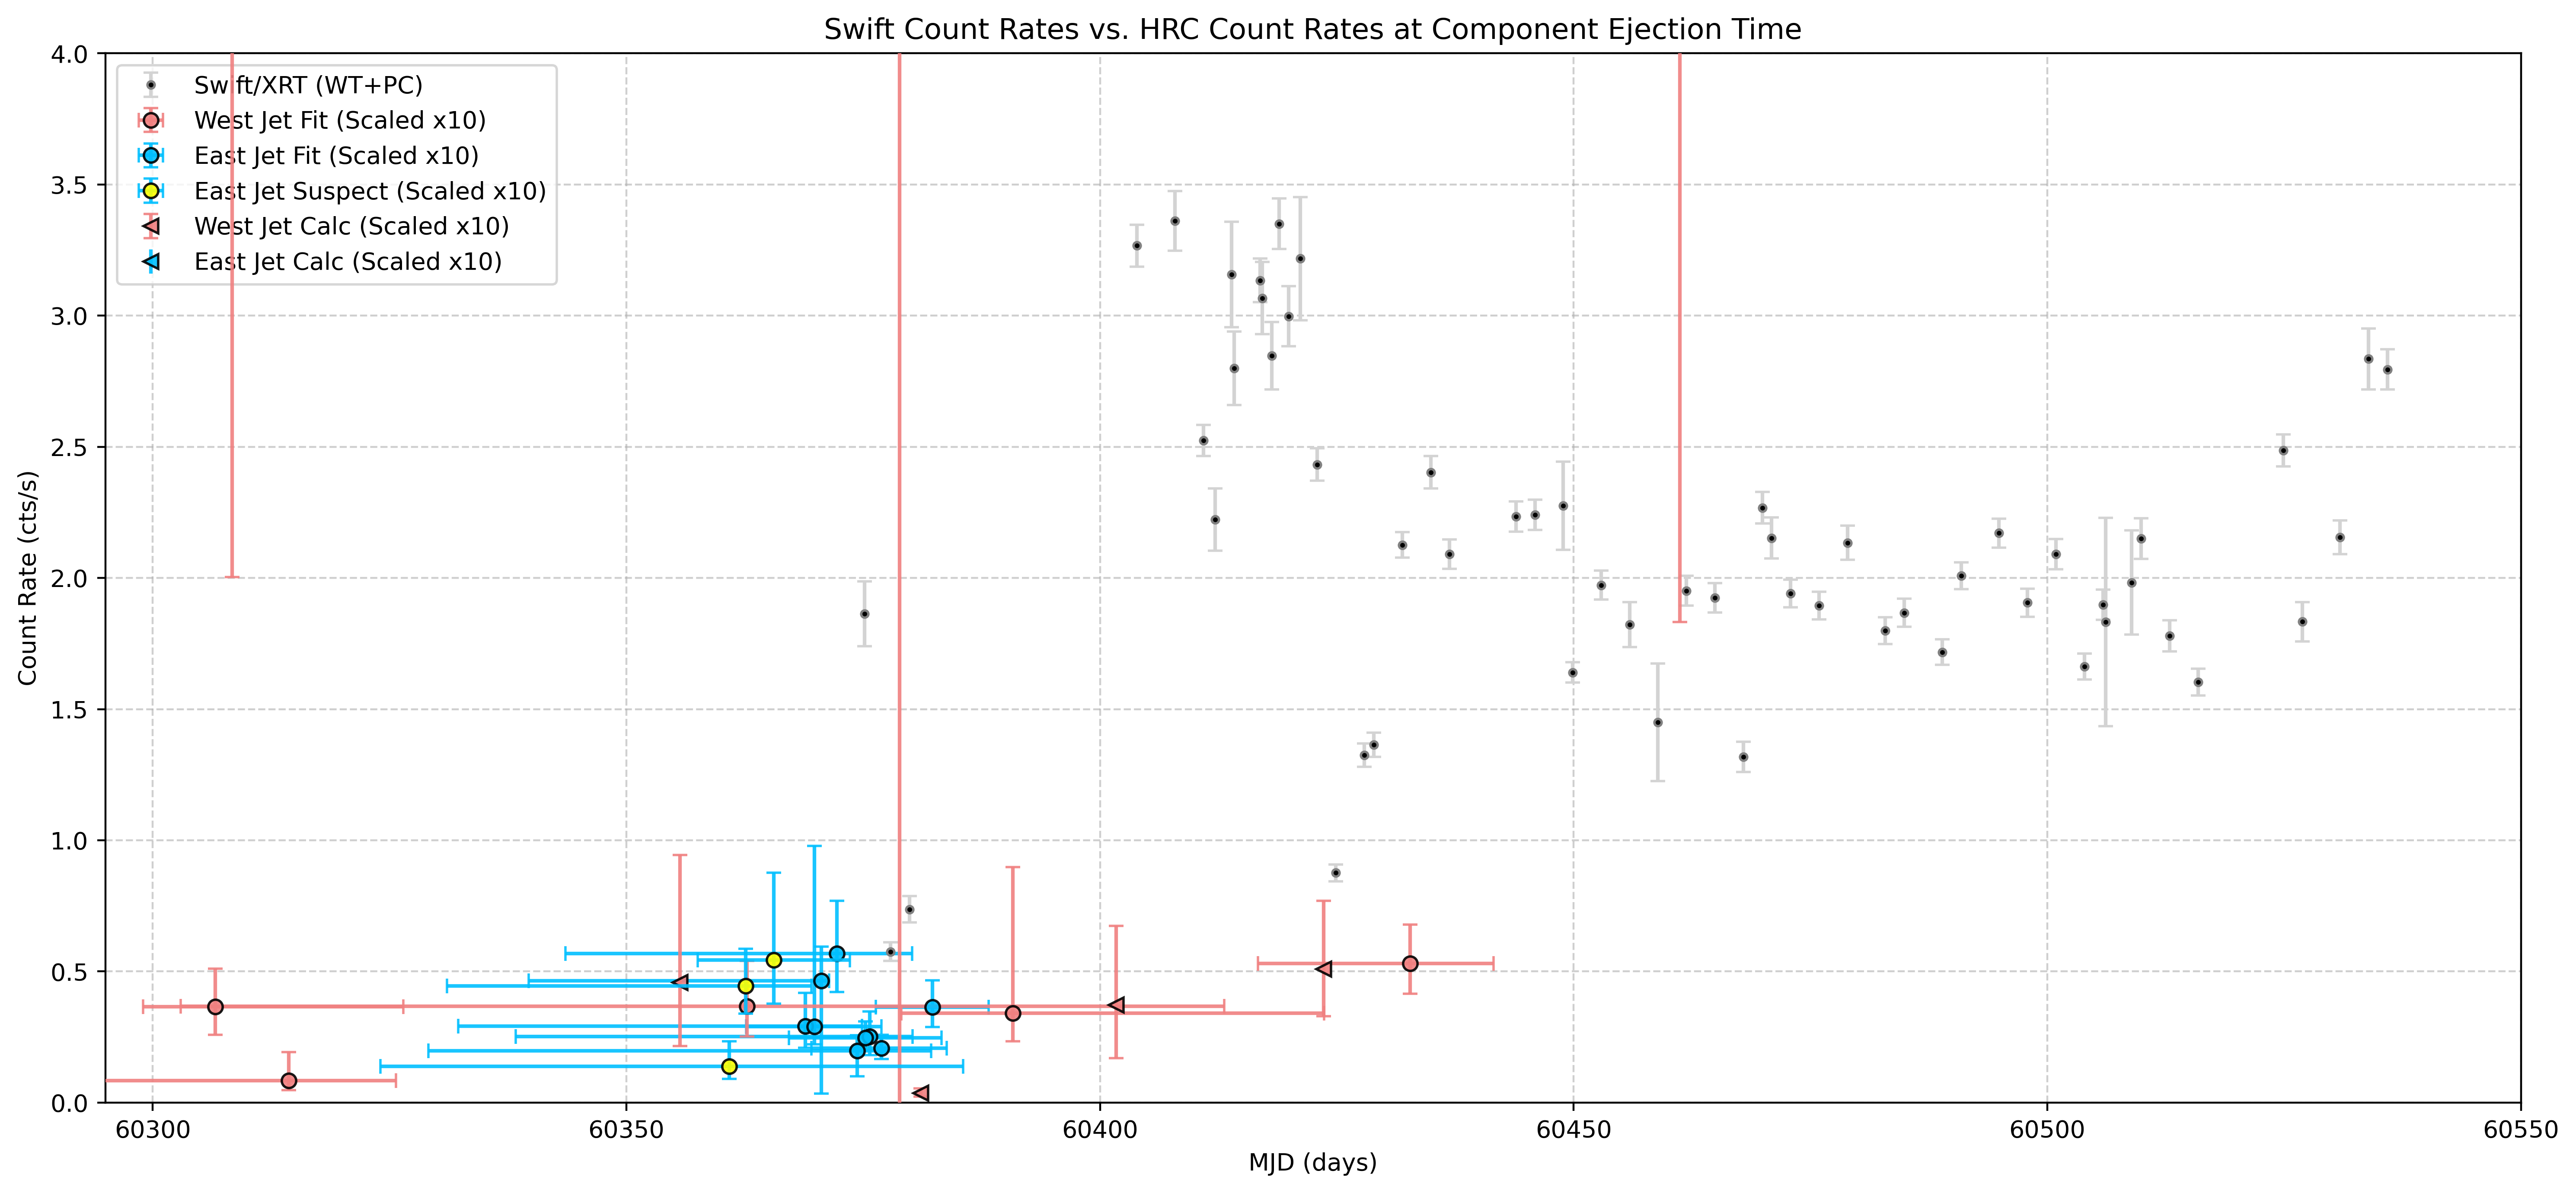

In [10]:
# --- Load, Process, and Plot Data at Ejection Times ---

# --- (1) Define Scaling Factor ---
HRC_SCALE_FACTOR = 10.0

# --- (2) Load Ejection Time Data ---
ejection_file = '/Users/leodrake/Documents/MIT/ss433/HRC_2024/2Dfits/ss433-jet-fit-analysis-results-3comp-1sigma-jittercorr-empPSF-0000-4040.csv'
has_ejection_data = False
try:
    ejection_df = pd.read_csv(ejection_file)
    ejection_df['ejection_mjd'] = ejection_df['mjd'] - ejection_df['travel_time_days']

    # --- Calculate the asymmetric error on the ejection date ---
    ejection_df['ejection_mjd_err_pos'] = np.divide(
        ejection_df['travel_time_days'] * ejection_df['beta_err_pos'],
        ejection_df['beta'],
        out=np.zeros_like(ejection_df['travel_time_days']),
        where=(ejection_df['beta'] != 0)
    )
    ejection_df['ejection_mjd_err_neg'] = np.divide(
        ejection_df['travel_time_days'] * ejection_df['beta_err_neg'],
        ejection_df['beta'],
        out=np.zeros_like(ejection_df['travel_time_days']),
        where=(ejection_df['beta'] != 0)
    )
    has_ejection_data = True
except FileNotFoundError:
    print(f"Ejection data file not found: {ejection_file}")
except KeyError as e:
    print(f"Error: Missing expected column in ejection file: {e}")
    has_ejection_data = False

# --- (3) Merge HRC data with Ejection data ---
if has_ejection_data:
    hrc_data_to_merge = df[['obs_id', 'component', 'nominal', 'minus_err', 'plus_err']].copy()
    ejection_data_to_merge = ejection_df[[
        'obs_id', 'component_name', 'ejection_mjd', 'method', 
        'ejection_mjd_err_pos', 'ejection_mjd_err_neg'
    ]].copy()

    plot_df = pd.merge(
        hrc_data_to_merge,
        ejection_data_to_merge,
        left_on=['obs_id', 'component'],
        right_on=['obs_id', 'component_name']
    )

    # --- Prepare data subsets for plotting based on method ---
    g2_data = plot_df[plot_df['component'] == 'g2'].copy()
    g2_fit_data = g2_data[g2_data['method'] == 'fit']
    g2_calc_data = g2_data[g2_data['method'] != 'fit']

    g4_data = plot_df[plot_df['component'] == 'g3']
    g4_fit_data = g4_data[g4_data['method'] == 'fit']
    g4_calc_data = g4_data[g4_data['method'] != 'fit']

    # --- NEW: Identify and separate the first 3 suspect g2 components ---
    # Sort all g2 data by ejection time and get the obs_ids of the first three
    suspect_obs_ids = g2_data.sort_values('ejection_mjd').head(3)['obs_id'].tolist()

    # Split the 'fit' g2 data into suspect and normal
    g2_fit_suspect = g2_fit_data[g2_fit_data['obs_id'].isin(suspect_obs_ids)]
    g2_fit_normal = g2_fit_data[~g2_fit_data['obs_id'].isin(suspect_obs_ids)]
    
    # Split the 'calc' g2 data into suspect and normal
    g2_calc_suspect = g2_calc_data[g2_calc_data['obs_id'].isin(suspect_obs_ids)]
    g2_calc_normal = g2_calc_data[~g2_calc_data['obs_id'].isin(suspect_obs_ids)]


# --- (4) Load Swift XRT data (WT+PC) ---
swift_file = "/Users/leodrake/Documents/MIT/ss433/swift-hrc-data.txt"
swift_list = []
try:
    with open(swift_file, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith(("!", "NO", "#")):
                continue
            tok = line.split()
            if len(tok) < 6:
                continue
            try:
                mjd, rate, err_low, err_high = map(float, [tok[0], tok[3], tok[4], tok[5]])
                swift_list.append((mjd, rate, 0.5 * (abs(err_low) + abs(err_high))))
            except (ValueError, IndexError):
                continue
except FileNotFoundError:
    print(f"Error: Swift data file not found at {swift_file}")

if swift_list:
    swift_arr = np.array(swift_list)
    order = np.argsort(swift_arr[:, 0])
    swift_dates, swift_rate, swift_err = swift_arr[order].T
else:
    swift_dates, swift_rate, swift_err = np.array([]), np.array([]), np.array([])

# --- (5) Plot Scaled HRC rates at Ejection Times vs. Swift Rates ---
if swift_dates.size > 0 and has_ejection_data:
    fig, ax = plt.subplots(figsize=(15, 7))

    # Plot Swift raw whole-source (WT + PC)
    ax.errorbar(
        swift_dates, swift_rate, yerr=swift_err,
        fmt='.', markerfacecolor='k', markeredgecolor='gray',
        color='gray', ecolor='lightgray', capsize=3, alpha=1, zorder=10,
        label='Swift/XRT (WT+PC)'
    )

    # Plot NORMAL g2 'fit' points
    ax.errorbar(
        x=g2_fit_normal['ejection_mjd'], y=g2_fit_normal['nominal'] * HRC_SCALE_FACTOR,
        xerr=[np.abs(g2_fit_normal['ejection_mjd_err_neg']), np.abs(g2_fit_normal['ejection_mjd_err_pos'])],
        yerr=[g2_fit_normal['minus_err'] * HRC_SCALE_FACTOR, g2_fit_normal['plus_err'] * HRC_SCALE_FACTOR],
        fmt='o', linestyle='', color='deepskyblue', markeredgecolor='black', ecolor='deepskyblue', capsize=3,
        alpha=0.9, zorder=10,
        label=f'East Jet Fit (Scaled x{int(HRC_SCALE_FACTOR)})'
    )
    # Plot NORMAL g2 'calc' points
    ax.errorbar(
        x=g2_calc_normal['ejection_mjd'], y=g2_calc_normal['nominal'] * HRC_SCALE_FACTOR,
        yerr=[g2_calc_normal['minus_err'] * HRC_SCALE_FACTOR, g2_calc_normal['plus_err'] * HRC_SCALE_FACTOR],
        fmt='<', linestyle='', color='deepskyblue', ecolor='deepskyblue', markeredgecolor='k', capsize=3,
        alpha=0.9, zorder=11,
        label=f'East Jet Calc (Scaled x{int(HRC_SCALE_FACTOR)})'
    )
    
    # Plot SUSPECT g2 'fit' points with yellow face color
    ax.errorbar(
        x=g2_fit_suspect['ejection_mjd'], y=g2_fit_suspect['nominal'] * HRC_SCALE_FACTOR,
        xerr=[np.abs(g2_fit_suspect['ejection_mjd_err_neg']), np.abs(g2_fit_suspect['ejection_mjd_err_pos'])],
        yerr=[g2_fit_suspect['minus_err'] * HRC_SCALE_FACTOR, g2_fit_suspect['plus_err'] * HRC_SCALE_FACTOR],
        fmt='o', linestyle='', markerfacecolor='yellow', markeredgecolor='black', ecolor='deepskyblue', capsize=3,
        alpha=0.9, zorder=12,
        label=f'East Jet Suspect (Scaled x{int(HRC_SCALE_FACTOR)})'
    )
    # Plot SUSPECT g2 'calc' points with yellow face color
    ax.errorbar(
        x=g2_calc_suspect['ejection_mjd'], y=g2_calc_suspect['nominal'] * HRC_SCALE_FACTOR,
        yerr=[g2_calc_suspect['minus_err'] * HRC_SCALE_FACTOR, g2_calc_suspect['plus_err'] * HRC_SCALE_FACTOR],
        fmt='<', linestyle='', markerfacecolor='yellow', markeredgecolor='black', ecolor='deepskyblue', capsize=3,
        alpha=0.9, zorder=13,
        label='_nolegend_' # Avoid duplicate suspect label
    )

    # Plot g4 'fit' points (unchanged)
    ax.errorbar(
        x=g4_fit_data['ejection_mjd'], y=g4_fit_data['nominal'] * HRC_SCALE_FACTOR,
        xerr=[np.abs(g4_fit_data['ejection_mjd_err_neg']), np.abs(g4_fit_data['ejection_mjd_err_pos'])],
        yerr=[g4_fit_data['minus_err'] * HRC_SCALE_FACTOR, g4_fit_data['plus_err'] * HRC_SCALE_FACTOR],
        fmt='o', linestyle='', color='lightcoral', markeredgecolor='black', ecolor='lightcoral', capsize=3,
        alpha=0.9, zorder=10,
        label=f'West Jet Fit (Scaled x{int(HRC_SCALE_FACTOR)})'
    )
    # Plot g4 'calc' points (unchanged)
    ax.errorbar(
        x=g4_calc_data['ejection_mjd'], y=g4_calc_data['nominal'] * HRC_SCALE_FACTOR,
        yerr=[g4_calc_data['minus_err'] * HRC_SCALE_FACTOR, g4_calc_data['plus_err'] * HRC_SCALE_FACTOR],
        fmt='<', linestyle='', color='lightcoral', ecolor='lightcoral', markeredgecolor='black', capsize=3,
        alpha=0.9, zorder=11,
        label=f'West Jet Calc (Scaled x{int(HRC_SCALE_FACTOR)})'
    )

    ax.set_xlabel("MJD (days)")
    ax.set_ylabel("Count Rate (cts/s)")
    ax.set_title("Swift Count Rates vs. HRC Count Rates at Component Ejection Time")
    
    # --- Reorder Legend ---
    handles, labels = ax.get_legend_handles_labels()
    
    desired_order = [
        'Swift/XRT (WT+PC)',
        f'West Jet Fit (Scaled x{int(HRC_SCALE_FACTOR)})',
        f'East Jet Fit (Scaled x{int(HRC_SCALE_FACTOR)})',
        f'East Jet Suspect (Scaled x{int(HRC_SCALE_FACTOR)})',
        f'West Jet Calc (Scaled x{int(HRC_SCALE_FACTOR)})',
        f'East Jet Calc (Scaled x{int(HRC_SCALE_FACTOR)})'
    ]
    
    label_handle_map = dict(zip(labels, handles))
    reordered_handles = [label_handle_map[label] for label in desired_order if label in label_handle_map]
    
    ax.legend(handles=reordered_handles, loc='upper left')

    ax.set_xlim(60295, 60550)
    ax.set_ylim(0,4)
    ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [7]:
import ipywidgets as widgets
from ipywidgets import interact, fixed

# --- 1. Load Data and Parameters ---
# Ensure the CSV file is accessible from this notebook
try:
    df_interactive = pd.read_csv(CSV_INPUT_PATH)
    obs_id_list = sorted(df_interactive['obs_id'].unique())
    print("Data loaded for interactive plot.")
except NameError:
    print("Please make sure CSV_INPUT_PATH is defined and the data loading cell has been run.")
    df_interactive = pd.DataFrame()
    obs_id_list = []

# Load the full ephemeris model for the overlay
params_full = load_ss433_params(source='full_russian')

# --- 2. Create the Interactive Plotting Function ---
def interactive_beta_plot(obs_id, base_beta):
    """
    Plots an observation and overlays the full model, with beta controlled by a slider.
    """
    if df_interactive.empty:
        print("DataFrame is empty. Cannot generate plot.")
        return

    # --- Get observation data ---
    group = df_interactive[df_interactive['obs_id'] == obs_id]
    if group.empty:
        print(f"No data found for Obs ID: {obs_id}")
        return
        
    blue_data = group[group['component'] == 'g2'].iloc[0]
    red_comp_name = sorted(group['component'].unique())[-1]
    red_data = group[group['component'] == red_comp_name].iloc[0]
    mjd_obs = blue_data['mjd']

    # --- Create the plot ---
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    
    # --- Plot observed data points with error bars ---
    ax.errorbar(np.deg2rad(blue_data['PA']), blue_data['radius'], 
                yerr=[[abs(blue_data['radius_minus_err'])], [abs(blue_data['radius_plus_err'])]], 
                xerr=[[np.deg2rad(abs(blue_data['PA_err_minus']))], [np.deg2rad(abs(blue_data['PA_err_plus']))]], 
                fmt='o', color='blue', ecolor='gray', capsize=4, zorder=5, label="Observed Blue Jet")
    
    ax.errorbar(np.deg2rad(red_data['PA']), red_data['radius'], 
                yerr=[[abs(red_data['radius_minus_err'])], [abs(red_data['radius_plus_err'])]], 
                xerr=[[np.deg2rad(abs(red_data['PA_err_minus']))], [np.deg2rad(abs(red_data['PA_err_plus']))]], 
                fmt='o', color='red', ecolor='gray', capsize=4, zorder=5, label="Observed Red Jet")

    # --- Plot the full model with the beta from the slider ---
    temp_params = params_full.copy()
    temp_params['beta'] = base_beta # Use the slider value
    
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=mcolors.Normalize(vmin=1.0, vmax=162.5))
    _plot_jet_trajectories_on_ax(ax, mjd_obs, temp_params, mappable, r_max=2.0)
    
    # --- Set plot aesthetics ---
    max_rad = max(blue_data['radius_plus_err'], red_data['radius_plus_err'])
    ax.set_rmin(0)
    ax.set_rmax(1.4)
    ax.set_title(f"Model Overlay for Obs ID: {obs_id}\nBase Beta = {base_beta:.4f}", pad=20)
    ax.legend()
    plt.show()

# --- 3. Create and Display the Widgets ---
# continuous_update=False is key to preventing choppiness
beta_slider = widgets.FloatSlider(
    min=0.2, 
    max=0.32, 
    step=0.0005, 
    value=params_full['beta'], 
    description='Beta:',
    continuous_update=False, 
    readout_format='.4f',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

obs_id_dropdown = widgets.Dropdown(
    options=obs_id_list,
    description='Obs ID:',
    style={'description_width': 'initial'}
)

# Link the widgets to the plotting function
interact(interactive_beta_plot, obs_id=obs_id_dropdown, base_beta=beta_slider);

Data loaded for interactive plot.
Loaded 'full_russian' ephemeris (Cherepaschuk 2025).


interactive(children=(Dropdown(description='Obs ID:', options=(26568, 26569, 26570, 26571, 26572, 26573, 26574…